# Import packages

In [31]:
import warnings
warnings.filterwarnings('ignore')
from copy import deepcopy
import pickle
# import psycopg2
import pandas as pd
import numpy as np

from time import time

from sklearn import datasets, metrics, svm, linear_model
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, RidgeClassifier, LassoCV, LogisticRegression, LogisticRegression, LogisticRegressionCV, SGDClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.extmath import density

import scipy.stats as stats
np.set_printoptions(precision=4)

import statsmodels.formula.api as smf
import statsmodels.api as sm

import en_core_web_sm
import nltk
import nltk.data
import spacy
import textacy
from tqdm import tqdm_notebook
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns

plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load data

In [32]:
# Load restaurant data
restaurants = pd.read_pickle('/Users/mai/Desktop/yelp_dataset/to_submit/restaurants_clean.pickle')

In [36]:
# Check the data
restaurants.head()

,business_id,review_id,minyear,maxyear,estimated_opearating_years,total_checkins,total_checkinyear_count,city,business_status,latitude,...,food_type_Seafood,food_type_Soup,food_type_Steakhouses,food_type_Sushi Bars,food_type_Tacos,food_type_Tapas Bars,food_type_Uzbek,food_type_Waffles,food_type_Wraps,prediction_col
1,--6MefnULPED_I942VcFNA,46,2011,2018,7,167,8,Richmond Hill,1,43.841694,...,0,0,0,0,0,0,0,0,0,successful
2,--7zmmkVg-IMGaXbuVd0SQ,59,2014,2018,4,180,5,Huntersville,1,35.437106,...,0,0,0,0,0,0,0,0,0,successful
3,--9e1ONYQuAa-CB_Rrw7Tw,1661,2010,2018,8,2770,9,Las Vegas,1,36.123183,...,0,0,1,0,0,0,0,0,0,successful
4,--DaPTJW3-tB1vP-PfdTEg,49,2012,2018,6,95,7,Toronto,1,43.677807,...,0,0,0,0,0,0,0,0,0,successful
5,--FBCX-N37CMYDfs790Bnw,142,2010,2018,8,528,9,Henderson,1,35.978679,...,0,0,0,0,0,0,0,0,0,successful


In [37]:
# Load review data
reviewdf = pd.read_pickle('/Users/mai/Desktop/yelp_dataset/to_submit/reviewdf.pickle')

In [38]:
# Check the data
reviewdf.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1.0,Q1sbwvVQXV2734tPgoKj4Q,1.0,Total bill for this horrible service? Over $8G...,6.0,hG7b0MtEbXx5QzbzE6C_VA
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0.0,GJXCdrto3ASJOqKeVWPi6Q,5.0,I *adore* Travis at the Hard Rock's new Kelly ...,0.0,yXQM5uF2jS6es16SJzNHfg
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0.0,2TzJjDVDEuAW6MR5Vuc1ug,5.0,I have to say that this office really has it t...,3.0,n6-Gk65cPZL6Uz8qRm3NYw
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0.0,yi0R0Ugj_xUx_Nek0-_Qig,5.0,Went in for a lunch. Steak sandwich was delici...,0.0,dacAIZ6fTM6mqwW5uxkskg
4,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0.0,11a8sVPMUFtaC7_ABRkmtw,1.0,Today was my second out of three sessions I ha...,7.0,ssoyf2_x0EQMed6fgHeMyQ


In [33]:
# Check the DataFrame size
restaurants.shape

(57484, 201)

In [15]:
# Check the DataFrame size
reviewdf.shape

(6685902, 9)

# Create a sample dataframe with Review information

The original dataframe is too big and it took long time to obtain sentiment scores
I decided to use 1% of total reviews randomly to make the process more efficient

In [35]:
# Check the distribution of target values
restaurants.prediction_col.value_counts()

successful    38588
failed        18896
Name: prediction_col, dtype: int64

In [ ]:
#restaurants.sample(weights=restaurants['prediction_col'].map(lambda x: 1/3 if x==1 else 2/3), n=10000).prediction_col.value_counts()
#sampledf = restaurants.sample(weights=restaurants['prediction_col'].map(lambda x: 1/2 if x==1 else 1/2), n=10000)

In [ ]:
# Extract reviews of restaurants that are in the 'restaurants' DataFrame
reviewdf2 = reviewdf[reviewdf.business_id.isin(restaurants.business_id) == True]

In [ ]:
# Group the reviews by business_id
reviewdf3 = pd.DataFrame(reviewdf2.groupby('business_id').count()['review_id']).reset_index()

In [ ]:
# Extract restaurants that have more than 50 reviews
# This is for future use - I wanted to remove restaurants with less than 50 reviews
reviewdf4 = reviewdf3[reviewdf3.review_id > 50]

In [ ]:
# Extract reviews based on the businesses in the 'reviewdf4' DataFrame
reviewdf5 = reviewdf[reviewdf.business_id.isin(reviewdf4.business_id) == True]

In [ ]:
# Create a prediction column
restaurants.prediction_col = restaurants.prediction_col.replace('successful', 1)
restaurants.prediction_col = restaurants.prediction_col.replace('failed', 0)

prediction = restaurants[['business_id', 'prediction_col']]

In [ ]:
# Put all data in a DataFrame
reviewdf6 = reviewdf5.merge(prediction, on='business_id')

In [ ]:
# Create a sample dataset
reviewdf6.sample(weights=reviewdf6['prediction_col'].map(lambda x: 1/2 if x==1 else 1/2), n=10000).prediction_col.value_counts()

In [ ]:
# Define which column I use as y
y = reviewdf6.prediction_col

In [327]:
# Check the baseline
# Failed to create a balanced dataset
baseline = y.value_counts()[1]/len(y)
baseline

0.863674880520625

In [334]:
# Re-try creating a dataset
# Check the distribution of target values
reviewdf6_sucessful = reviewdf6[reviewdf6.prediction_col == 1]
print(reviewdf6_sucessful.shape)
reviewdf6_failed = reviewdf6[reviewdf6.prediction_col == 0]
print(reviewdf6_sucessful.shape)

(2879353, 10)
(2879353, 10)


In [335]:
# Check the distribition in the sample dataset
review_s_df = reviewdf6_sucessful.sample(frac=0.02, random_state=1)
print(review_s_df.shape)
review_f_df = reviewdf6_failed.sample(frac=0.1, random_state=1)
print(review_f_df.shape)

(57587, 10)
(45449, 10)


In [340]:
# Put all data in a DataFrame
reviewdf7 = pd.concat([review_s_df, review_f_df], ignore_index=True)

# <font color='red'> DO NOT UPDATE OR DELETE BELOW </font>

In [23]:
# Define which column I use as y
y = reviewdf7.prediction_col

# Check the distribution
# Successfully created a more balanced sample dataset
baseline = y.value_counts()[1]/len(y)
baseline

0.4953233445533347

# Create the sen_dict from the word_sentiments data frame

In [29]:
# The word sentiments are in the file word_sentiments.csv.
sents = pd.read_csv('/Users/mai/Desktop/DSI9/DSI9-lessons/week06/day5_sentiment_analysis/sentiment-analysis-lab/datasets/word_sentiments.csv')

In [30]:
# Check the DataFrame
sents.head()

,pos,word,pos_score,neg_score,objectivity,pos_vs_neg
0,ADJ,.22-caliber,0.0,0.0,1.0,0.0
1,ADJ,.22-calibre,0.0,0.0,1.0,0.0
2,ADJ,.22_caliber,0.0,0.0,1.0,0.0
3,ADJ,.22_calibre,0.0,0.0,1.0,0.0
4,ADJ,.38-caliber,0.0,0.0,1.0,0.0


In [ ]:
# Create a function that converts data to sentiment scores
def sent_converter(data):
    analyzer = SentimentIntensityAnalyzer()
    vader_scores = testdf['text'].map(analyzer.polarity_scores)
    dvec = DictVectorizer()

    vader_scores = dvec.fit_transform(vader_scores)
    vader_scores

In [ ]:
# Instantiate SentimentIntensityAnalyzer()
analyzer = SentimentIntensityAnalyzer()

In [ ]:
# Apply analyzer to 'text' column
vader_scores = reviewdf7['text'].map(analyzer.polarity_scores)

In [ ]:
# Apply DictVectorizer to create columns containing sentiment scores
dvec = DictVectorizer()
vader_scores = dvec.fit_transform(vader_scores)

In [ ]:
# Create column names
for i, col in enumerate(dvec.feature_names_):
    reviewdf7['vader_{}'.format(col)] = vader_scores[:, i].toarray().ravel()

In [ ]:
# Create categories for future use
vader_result_col = []

for i in reviewdf7['vader_compound']:
    if i >= 0.05:
        vader_result_col.append('positive')
    elif i <=  - 0.05:
        vader_result_col.append('negative')
    else:
        vader_result_col.append('neutral')

In [ ]:
# Create a new column
reviewdf7['vader_result'] = vader_result_col

In [ ]:
# Create categories for star ratings
star_category = []

for i in reviewdf7['stars']:
    if i >= 4:
        star_category.append('positive')
    elif i <=  2:
        star_category.append('negative')
    else:
        star_category.append('neutral')

In [ ]:
# Create a new column
reviewdf7['star_category'] = star_category

In [ ]:
# Pickle results 
reviewdf7.to_pickle('review_sentimentanalysis.pickle')

In [50]:
# Check if I successfully pickled the data
review_sa = pd.read_pickle('/Users/mai/Desktop/yelp_dataset/to_submit/review_sentimentanalysis.pickle')

In [51]:
# Check the DataFrame
review_sa.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,prediction_col,vader_compound,vader_neg,vader_neu,vader_pos,vader_result,star_category
0,lImzcOqB4etkPR9WT50lDg,0,2011-01-26 22:37:59,1.0,8SQqvzIkjGrzp5NFHjUurg,2.0,I called at 3:30 before I left home and verifi...,3.0,IC7NLIeWhS45_aEE_8aVUg,1,0.3818,0.034,0.910,0.056,positive,negative
1,hihud--QRriCYZw1zZvW4g,0,2018-07-17 00:15:46,0.0,SNPAXf7PkiAloR0e_Rf3EQ,5.0,Obsessed. So freakin good. Great service too. ...,0.0,Cp2xnws7dYQRsyYzszsLiw,1,0.8654,0.068,0.518,0.414,positive,positive
2,t5Ip9ggWaam6qAUH0WPKVg,0,2016-04-08 04:32:56,0.0,7tUmfqnN1brQNS3S5Fvzqw,5.0,My husband found this place bc I'm pregnant an...,0.0,Xv8GPBvUizxe2aZjW5hTRw,1,0.8802,0.045,0.720,0.234,positive,positive
3,Ey1iEY8yAQG5MEBZPQ_niQ,9,2015-09-08 04:49:51,4.0,9U3wDwvfkbW6e9dENmF_AQ,5.0,Viva Fremont! \nThis was the most fun casino d...,12.0,WWWujmZ95y0a2RR5_kQ9sw,1,0.9853,0.036,0.774,0.189,positive,positive
4,2g6x4ISNiMxFnotBuwmZmw,0,2017-07-09 18:27:28,0.0,Rqla75aWPeieeMTbkEM6-Q,2.0,The food here is great and very surprising for...,0.0,iTxK9lco6b4mb1QUz6PQOw,1,0.8955,0.030,0.776,0.194,positive,negative


In [52]:
# Check the size
review_sa.shape

(134284, 16)

In [53]:
# Check the number of reviews per business_id
reviewcount = pd.DataFrame(review_sa.groupby('business_id').count()['review_id']).reset_index()
reviewcount.rename(columns={'review_id': 'review_count'}, inplace=True)

In [54]:
# It will take many hours to process SentimentIntensityAnalyzer()... 
reviewcount.sort_values(by='review_count', ascending=False).head()

,business_id,review_count
20515,cYwJA2A6I12KNkm2rtXd5g,546
11043,KskYqH1Bi7Z_61pH6Om8pg,426
21622,eoHdUeQDNgQ6WYEnP2aiRw,411
14232,RESDUcs7fIiihp38-d6_6g,186
13791,QJR4qBUHegWEozSQrGmBPw,180


# Group reviews per business_id

In [55]:
# Clean up reviews
review_sa['text'] = review_sa['text'].apply(lambda text: (text+' ')).apply(lambda text: text.replace('\n', ''))

In [56]:
# Group reviews per business id
review_sa2 = pd.DataFrame(review_sa.groupby('business_id').mean())
review_sa2 = review_sa2.reset_index()

# Add prediction variables to review dataframe

In [57]:
# Create prediction variables
restaurants.prediction_col = restaurants.prediction_col.replace('successful', 1)
restaurants.prediction_col = restaurants.prediction_col.replace('failed', 0)

In [47]:
# Create a small dataset to run codes faster
prediction = restaurants[['business_id', 'prediction_col']]

In [59]:
# Merge the dataframe based on busienss_id
df = review_sa2.merge(restaurants, on='business_id')

# Delete duplicated columns

In [61]:
df.drop(columns='prediction_col_y', axis=1, inplace=True)

In [62]:
df.rename(columns={'prediction_col_x': 'prediction_col'}, inplace=True)

# Check the baseline

In [63]:
# Define which column to use as y
y = df.prediction_col

In [64]:
# Check the baseline
baseline = y.value_counts()[1]/len(y)
baseline

0.5860499674932664

In [65]:
# Check the DataFrame size
df.shape

(32301, 209)

# Check the correlation matrix of the variables 

In [66]:
crr_matrix = df.corr()

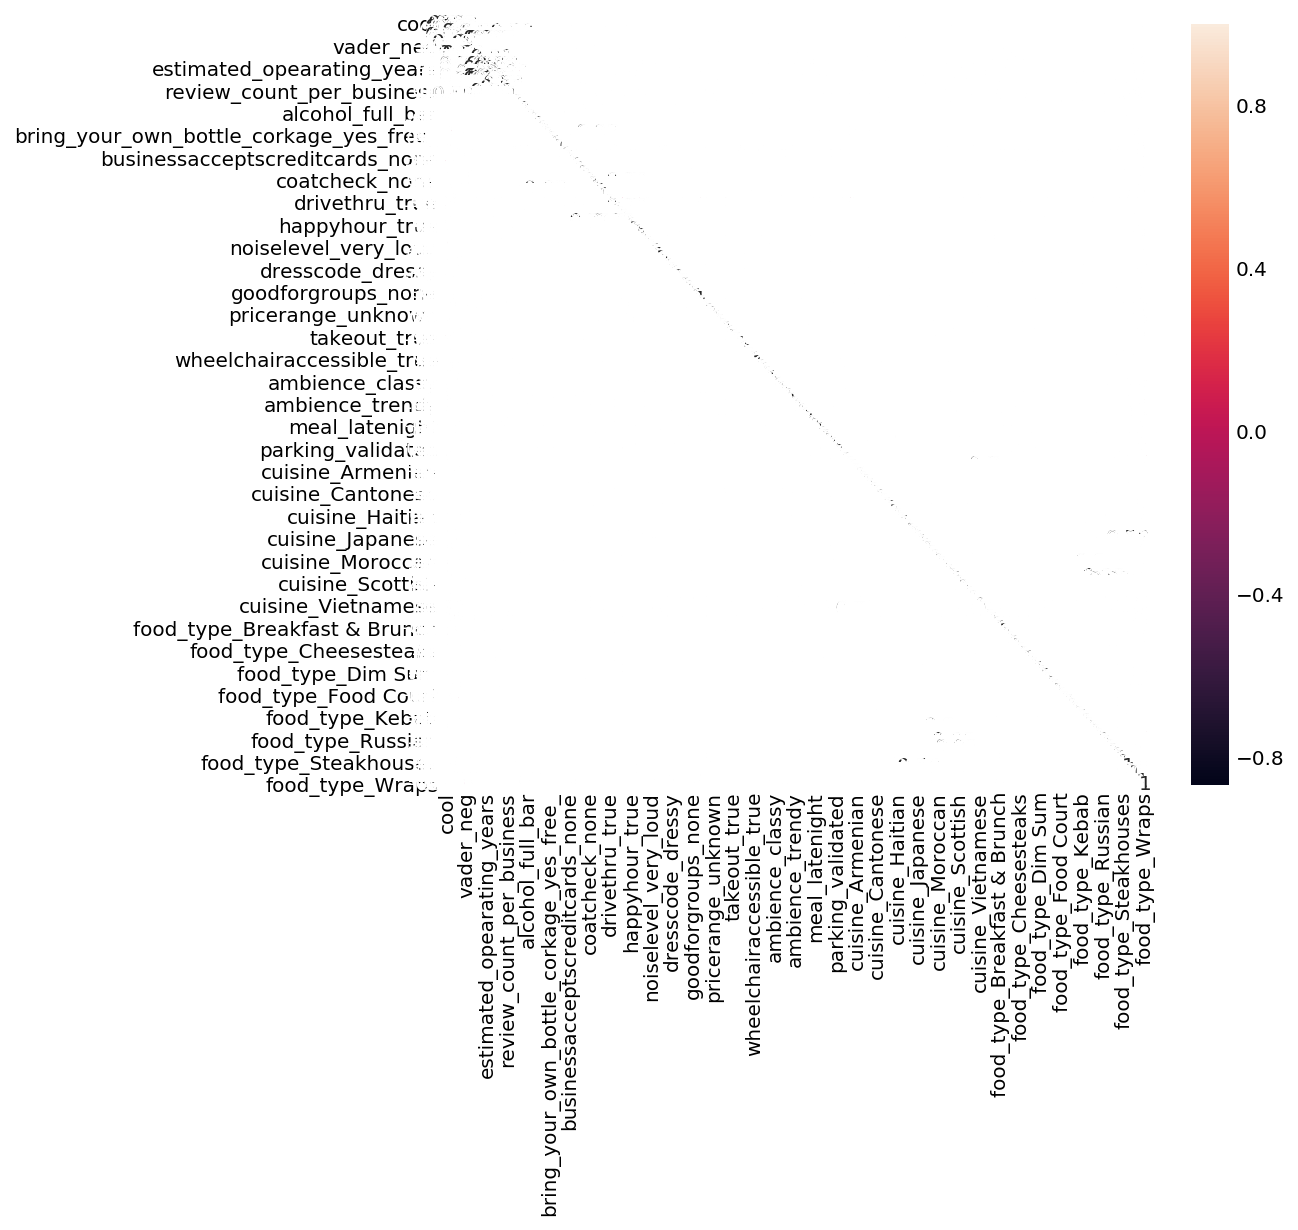

In [67]:
# Plot the correlation matrix
plt.figure(figsize=(7, 7))
sns.heatmap(crr_matrix, annot=True)
plt.show()

# Create training and test scores

In [68]:
# Define which columns to be used as X
X = df[['cool', 'funny', 'stars', 'useful',
       'vader_compound', 'vader_neg',
       'vader_neu', 'vader_pos']]

In [69]:
# Prepare datasets for modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, random_state=1)

In [70]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Fit a Logistic Regression CV

In [71]:
# Instantiate a model
model_lr = LogisticRegressionCV(Cs=100, solver='lbfgs', random_state=1)

In [72]:
# Fit a model
model_lr.fit(X_train, y_train)

LogisticRegressionCV(Cs=100, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [73]:
# Check the intercept
model_lr.intercept_

array([0.2722])

In [74]:
# Check the train score
model_lr.score(X_train, y_train)

0.5842724458204335

In [75]:
# Check the test score
model_lr.score(X_test, y_test)

0.5866509813633831

In [76]:
# Check the cross-validation score
cv_scores = cross_val_score(model_lr, X_train, y_train, cv=10).mean()
cv_scores

0.5840253751211553

In [77]:
# create a confusion matrix
pred_list = model_lr.predict_proba(X_train)

pred_result = pd.DataFrame(pred_list, y_train)
pred_result.reset_index(inplace=True)

model_lr.fit(X_train, y_train)
predictions = model_lr.predict(X_test)
confusion = confusion_matrix(y_test, predictions)
pd.DataFrame(confusion, columns=sorted(y_train.unique()),
             index=sorted(y_train.unique()))

,0.0,1.0
0.0,124,6562
1.0,114,9351


In [78]:
# Check the precision and recall score 
# The result below is without treshold being set 

yhat_lr = model_lr.predict(X_test)
yhat_pp_lr = model_lr.predict_proba(X_test)
print(classification_report(y_test, yhat_lr))

              precision    recall  f1-score   support

         0.0       0.52      0.02      0.04      6686
         1.0       0.59      0.99      0.74      9465

   micro avg       0.59      0.59      0.59     16151
   macro avg       0.55      0.50      0.39     16151
weighted avg       0.56      0.59      0.45     16151



In [79]:
# Check the misclassified items
pred_list = model_lr.predict_proba(X_train)
pred_result = pd.DataFrame(pred_list, y_train)
pred_result['actual'] = model_lr.predict(X_train)
pred_result.reset_index(inplace=True)
misclassified = pred_result[pred_result.prediction_col != pred_result.actual]
misclassified = misclassified.reindex(columns=['prediction_col', 'actual', 0, 1])
misclassified['difference'] = (misclassified[0] - misclassified[1]).round(2)
misclassified[:5]

,prediction_col,actual,0,1,difference
8,0.0,1.0,0.465524,0.534476,-0.07
9,0.0,1.0,0.406621,0.593379,-0.19
11,0.0,1.0,0.392602,0.607398,-0.21
16,0.0,1.0,0.396233,0.603767,-0.21
17,0.0,1.0,0.416864,0.583136,-0.17


In [80]:
# Create a dataframe to look at the coefficients
coef_df_lr = pd.DataFrame({'feature': X.columns,
                        'coef': model_lr.coef_[0],
                        'abs_coef': np.abs(model_lr.coef_[0])})

In [81]:
# Sort by absolute value of coefficient (magnitude)
coef_df_lr = coef_df_lr.sort_values(by='abs_coef', ascending=False)
coef_df_lr

,feature,coef,abs_coef
4,vader_compound,-0.112652,0.112652
3,useful,-0.085418,0.085418
2,stars,0.061460,0.061460
0,cool,0.047169,0.047169
1,funny,0.023321,0.023321
6,vader_neu,-0.009663,0.009663
7,vader_pos,0.006760,0.006760
5,vader_neg,0.002617,0.002617


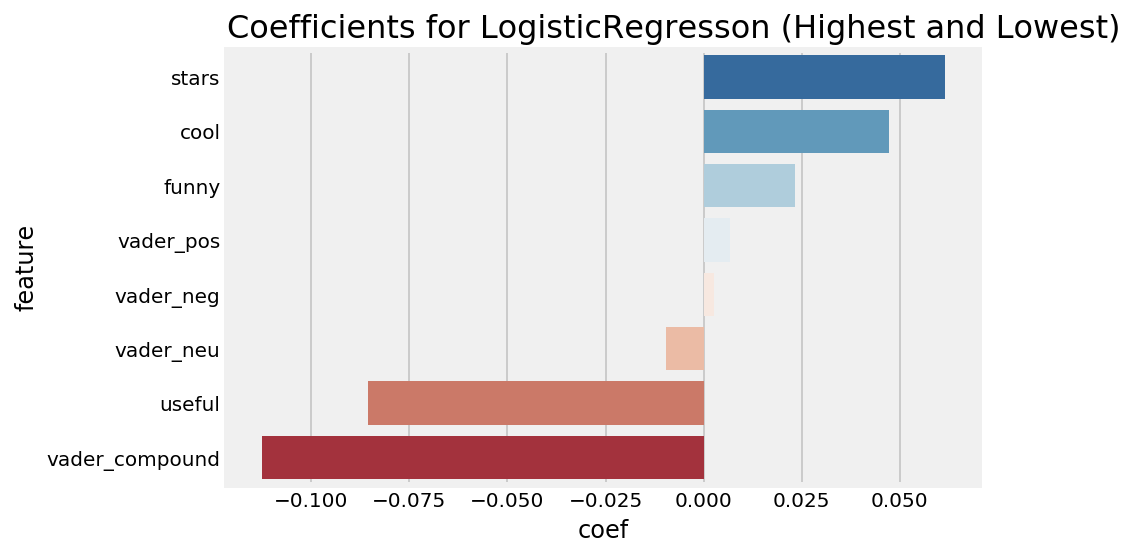

In [82]:
# Plot the coefficient table
sort_coef = pd.concat([coef_df_lr.sort_values(by='coef', ascending=False).head(5),
                      coef_df_lr.sort_values(by='coef', ascending=False).tail(5)])
sns.barplot(y = sort_coef.feature, x = sort_coef.coef, palette = "RdBu_r")
plt.title("Coefficients for LogisticRegresson (Highest and Lowest)", loc = 'left', fontsize = 16)
plt.show()

# Fit a Logistic Regression CV with a Ridge penalty

In [83]:
# Prepare the datasets for modeling
Xr = X.copy()

Xr_train, Xr_test, y_train, y_test = train_test_split(Xr, y, stratify=y, test_size=0.5, random_state=1)

Xr_train = scaler.fit_transform(Xr_train)
Xr_test = scaler.transform(Xr_test)

In [84]:
# Define StratifiedKFold
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

In [85]:
# Instantiate the model
lr_ridge = LogisticRegressionCV(penalty='l2', Cs=100, cv=kf)

In [86]:
# Fit the model, find the C_ value, and check train, test, cross-validation scores
lr_ridge.fit(Xr_train, y_train)
print(lr_ridge.C_)
print(lr_ridge.score(Xr_train, y_train))
print(lr_ridge.score(Xr_test, y_test))

cv_scores = cross_val_score(lr_ridge, Xr_train, y_train, cv=5).mean()
print(cv_scores)

[0.0001]
0.5855108359133127
0.5858460776422513
0.5846439628482972


In [87]:
# Check precision and recall scores
yhat_lr_ridge = lr_ridge.predict(Xr_test)
yhat_pp_ridge = lr_ridge.predict_proba(Xr_test)
print(classification_report(y_test, yhat_lr_ridge))

              precision    recall  f1-score   support

         0.0       0.20      0.00      0.00      6686
         1.0       0.59      1.00      0.74      9465

   micro avg       0.59      0.59      0.59     16151
   macro avg       0.39      0.50      0.37     16151
weighted avg       0.43      0.59      0.43     16151



In [88]:
# Check the misclassified items
pred_list_lr_ridge = lr_ridge.predict_proba(X_train)
pred_result_lr_ridge = pd.DataFrame(pred_list_lr_ridge, y_train)
pred_result_lr_ridge['actual'] = lr_ridge.predict(X_train)
pred_result_lr_ridge.reset_index(inplace=True)

misclassified_lr_ridge = pred_result_lr_ridge[pred_result_lr_ridge.prediction_col != pred_result_lr_ridge.actual]
misclassified_lr_ridge = misclassified_lr_ridge.reindex(columns=['prediction_col', 'actual', 0, 1])
misclassified_lr_ridge['difference'] = (misclassified_lr_ridge[0] - misclassified_lr_ridge[1]).round(2)
misclassified_lr_ridge[:5]

,prediction_col,actual,0,1,difference
8,0.0,1.0,0.427645,0.572355,-0.14
9,0.0,1.0,0.408681,0.591319,-0.18
11,0.0,1.0,0.411857,0.588143,-0.18
16,0.0,1.0,0.410932,0.589068,-0.18
17,0.0,1.0,0.411033,0.588967,-0.18


In [89]:
# Create a DataFrame to look at the coefficients
coef_df_lr_ridge = pd.DataFrame({'feature': X.columns,
                        'coef': lr_ridge.coef_[0],
                        'abs_coef': np.abs(lr_ridge.coef_[0])})

# Sort by absolute value of coefficient (magnitude)
coef_df_lr_ridge = coef_df_lr_ridge.sort_values(by='abs_coef', ascending=False)
coef_df_lr_ridge

,feature,coef,abs_coef
4,vader_compound,-0.030336,0.030336
3,useful,-0.026425,0.026425
2,stars,0.020221,0.020221
6,vader_neu,-0.014177,0.014177
7,vader_pos,0.011189,0.011189
5,vader_neg,0.002180,0.002180
0,cool,-0.001285,0.001285
1,funny,-0.000258,0.000258


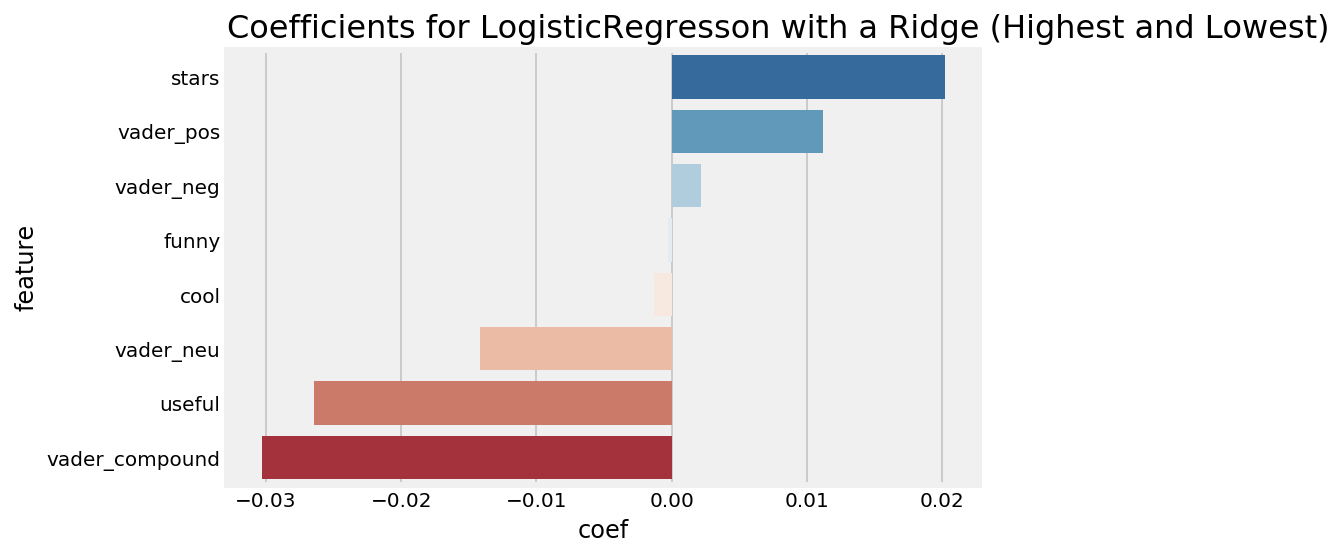

In [90]:
# Plot the coefficient table
sort_coef_lr_ridge = pd.concat([coef_df_lr_ridge.sort_values(by='coef', ascending=False).head(5),
                      coef_df_lr_ridge.sort_values(by='coef', ascending=False).tail(5)])
sns.barplot(y = sort_coef_lr_ridge.feature, x = sort_coef_lr_ridge.coef, palette = "RdBu_r")
plt.title("Coefficients for LogisticRegresson with a Ridge (Highest and Lowest)", loc = 'left', fontsize = 16)
plt.show()

# Fit a Logistic Regression CV with a Lasso penalty

In [91]:
# Prepare the datasets for modeling
Xl = X.copy()

Xl_train, Xl_test, y_train, y_test = train_test_split(Xl, y, stratify=y, test_size=0.5, random_state=1)

Xl_train = scaler.fit_transform(Xl_train)
Xl_test = scaler.transform(Xl_test)

In [92]:
# Instantiate the model
lr_lasso = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=10, cv=kf)
lr_lasso.fit(Xl_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None,
           cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
           random_state=None, refit=True, scoring=None, solver='liblinear',
           tol=0.0001, verbose=0)

In [93]:
# Define the best model
lasso_best = LogisticRegression(C=lr_lasso.C_[0], penalty='l1', solver='liblinear')

In [94]:
# Fit the model, find the C_ value, and check train and test scores
print(lr_lasso.C_)
print(lr_lasso.score(Xl_train, y_train))
print(lr_lasso.score(Xl_test, y_test))

[0.006]
0.584953560371517
0.5855364992879698


In [95]:
# Ceck cross-validation scores
cv_scores = cross_val_score(lasso_best, Xl_train, y_train, cv=5).mean()
print(cv_scores)

0.5845201238390093


In [96]:
# Check the precision and recall score
yhat_lr_lasso = lr_lasso.predict(Xr_test)
yhat_pp_lasso = lr_lasso.predict_proba(Xl_test)
print(classification_report(y_test, yhat_lr_lasso))

              precision    recall  f1-score   support

         0.0       0.44      0.00      0.01      6686
         1.0       0.59      1.00      0.74      9465

   micro avg       0.59      0.59      0.59     16151
   macro avg       0.52      0.50      0.37     16151
weighted avg       0.53      0.59      0.44     16151



In [97]:
# Check the misclassified items
pred_list_lr_lasso = lr_lasso.predict_proba(X_train)
pred_result_lr_lasso = pd.DataFrame(pred_list_lr_lasso, y_train)
pred_result_lr_lasso['actual'] = lr_lasso.predict(X_train)
pred_result_lr_lasso.reset_index(inplace=True)

misclassified_lr_lasso = pred_result_lr_lasso[pred_result_lr_lasso.prediction_col != pred_result_lr_lasso.actual]
misclassified_lr_lasso = misclassified_lr_lasso.reindex(columns=['prediction_col', 'actual', 0, 1])
misclassified_lr_lasso['difference'] = (misclassified_lr_lasso[0] - misclassified_lr_lasso[1]).round(2)
misclassified_lr_lasso[:5]

,prediction_col,actual,0,1,difference
8,0.0,1.0,0.431303,0.568697,-0.14
9,0.0,1.0,0.387310,0.612690,-0.23
11,0.0,1.0,0.384743,0.615257,-0.23
16,0.0,1.0,0.397242,0.602758,-0.21
17,0.0,1.0,0.397320,0.602680,-0.21


In [98]:
# Create a DataFrame to look at the coefficients
coef_df_lr_lasso = pd.DataFrame({'feature': Xl.columns,
                        'coef': lr_lasso.coef_[0],
                        'abs_coef': np.abs(lr_lasso.coef_[0])})

# Sort by absolute value of coefficient (magnitude)
coef_df_lr_lasso = coef_df_lr_lasso.sort_values(by='abs_coef', ascending=False)
coef_df_lr_lasso

,feature,coef,abs_coef
4,vader_compound,-0.097008,0.097008
2,stars,0.072317,0.072317
3,useful,-0.051494,0.051494
7,vader_pos,0.010871,0.010871
6,vader_neu,-0.006404,0.006404
0,cool,0.000000,0.000000
1,funny,0.000000,0.000000
5,vader_neg,0.000000,0.000000


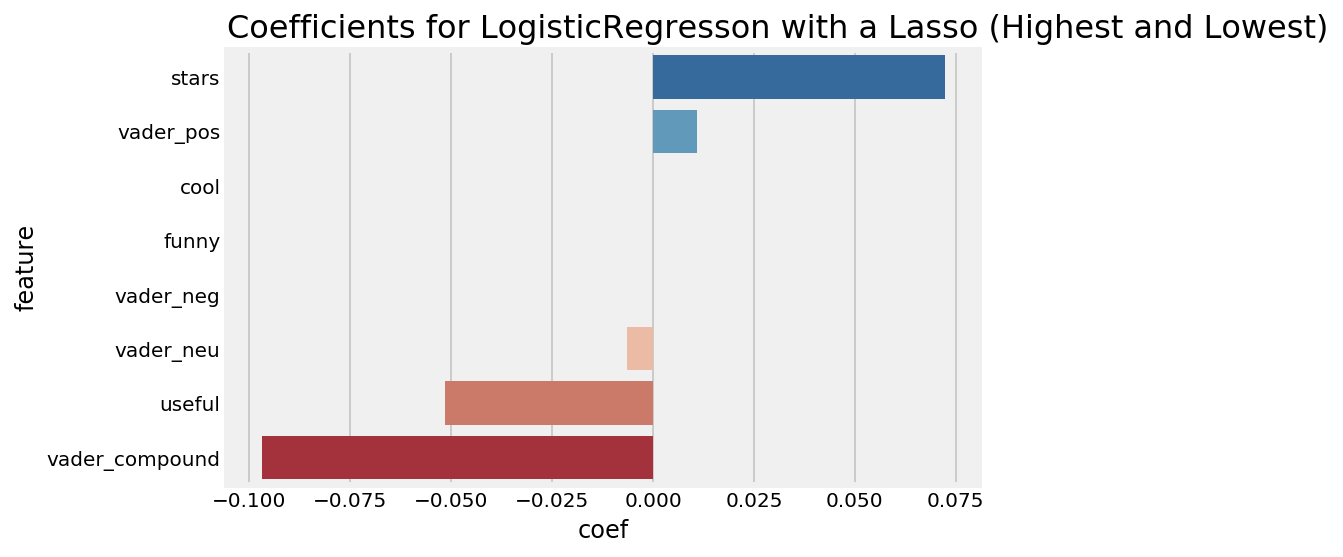

In [99]:
# Plot the coefficient table
sort_coef_lr_lasso = pd.concat([coef_df_lr_lasso.sort_values(by='coef', ascending=False).head(5),
                      coef_df_lr_lasso.sort_values(by='coef', ascending=False).tail(5)])
sns.barplot(y = sort_coef_lr_lasso.feature, x = sort_coef_lr_lasso.coef, palette = "RdBu_r")
plt.title("Coefficients for LogisticRegresson with a Lasso (Highest and Lowest)", loc = 'left', fontsize = 16)
plt.show()

# Use a Support Vector Machine

In [100]:
# Instantiate the model
clf_s = svm.SVC(C=1.0, kernel='poly', degree=3, gamma='scale', probability=True)

In [101]:
# Fit the model
clf_s.fit(X_train_std, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [102]:
# Check the train score 
clf_s.score(X_train_std, y_train)

0.5863777089783282

In [103]:
# Check the test score
clf_s.score(X_test_std, y_test)

0.5860937403256764

In [104]:
# Check the cross-validation score
cv_scores = cross_val_score(clf_s, X_train_std, y_train, cv=5).mean()
cv_scores

0.5856346749226006

In [117]:
baseline

0.5860499674932664

In [105]:
# Check the precision and recall scores
yhat_clf_s = clf_s.predict(X_test_std)
yhat_pp_clf_s = clf_s.predict_proba(X_test_std)
print(classification_report(y_test, yhat_clf_s))

              precision    recall  f1-score   support

         0.0       0.55      0.00      0.00      6686
         1.0       0.59      1.00      0.74      9465

   micro avg       0.59      0.59      0.59     16151
   macro avg       0.57      0.50      0.37     16151
weighted avg       0.57      0.59      0.43     16151



In [116]:
# Check the misclassified items
pred_list_clf_s = clf_s.predict_proba(X_train)
pred_result_clf_s = pd.DataFrame(pred_list_clf_s, y_train)
pred_result_clf_s['actual'] = clf_s.predict(X_train)
pred_result_clf_s.reset_index(inplace=True)

misclassified_clf_s = pred_result_clf_s[pred_result_clf_s.prediction_col != pred_result_clf_s.actual]
misclassified_clf_s = misclassified_clf_s.reindex(columns=['prediction_col', 'actual', 0, 1])
misclassified_clf_s['difference'] = (misclassified_clf_s[0] - misclassified_clf_s[1]).round(2)
misclassified_clf_s[:5]

,prediction_col,actual,0,1,difference
8,0.0,1.0,0.413428,0.586572,-0.17
9,0.0,1.0,0.413465,0.586535,-0.17
11,0.0,1.0,0.413564,0.586436,-0.17
16,0.0,1.0,0.413441,0.586559,-0.17
17,0.0,1.0,0.413476,0.586524,-0.17


# Use a Random Forest

In [107]:
# Prepare the datasets for modeling
y_cgrid = y.copy()
X_cgrid = X.copy()

Xcgrid_train, Xcgrid_test, y_cgrid_train, y_cgrid_test = train_test_split(X_cgrid, y, test_size=0.5, random_state=8)


Xcgrid_train = scaler.fit_transform(Xcgrid_train)
Xcgrid_test = scaler.transform(Xcgrid_test)

In [109]:
# Fit the model
tree_params = {'max_depth': np.arange(1, 100, 10)}

dt_classifier = DecisionTreeClassifier(criterion='gini',
                                    max_depth=None, 
                                    random_state=1)

dt_gridsearch = GridSearchCV(dt_classifier,
                              tree_params,
                              n_jobs=2, 
                              cv=5, 
                              verbose=1)

dt_gridsearch.fit(Xcgrid_train, y_cgrid_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    5.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'max_depth': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [110]:
# Show the parameters
dt_gridsearch.param_grid

{'max_depth': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])}

In [111]:
# Show the best score
dt_gridsearch.best_score_

0.5888544891640867

In [112]:
# Show evaluation scores
print(dt_gridsearch.score(Xcgrid_train, y_cgrid_train))
print(dt_gridsearch.score(Xcgrid_test, y_cgrid_test))
print(cross_val_score(dt_gridsearch, Xcgrid_train, y_cgrid_train, cv=5).mean())

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.5888544891640867
0.583245619466287
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    2.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.5888544891640867


[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    1.7s finished


In [113]:
# Check precision and recall scores
yhat_dt_gridsearch = dt_gridsearch.predict(Xcgrid_test)
yhat_pp_dt_gridsearch = dt_gridsearch.predict_proba(Xcgrid_test)
print(classification_report(y_cgrid_test, yhat_dt_gridsearch))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      6731
         1.0       0.58      1.00      0.74      9420

   micro avg       0.58      0.58      0.58     16151
   macro avg       0.29      0.50      0.37     16151
weighted avg       0.34      0.58      0.43     16151



In [114]:
# Check the misclassfied items
pred_list_dt_gridsearch = dt_gridsearch.predict_proba(X_train)
pred_result_dt_gridsearch = pd.DataFrame(pred_list_dt_gridsearch, y_train)
pred_result_dt_gridsearch['actual'] = dt_gridsearch.predict(X_train)
pred_result_dt_gridsearch.reset_index(inplace=True)

misclassified_dt_gridsearch = pred_result_dt_gridsearch[pred_result_dt_gridsearch.prediction_col != pred_result_dt_gridsearch.actual]
misclassified_dt_gridsearch = misclassified_dt_gridsearch.reindex(columns=['prediction_col', 'actual', 0, 1])
misclassified_dt_gridsearch['difference'] = (misclassified_dt_gridsearch[0] - misclassified_dt_gridsearch[1]).round(2)
misclassified_dt_gridsearch[:5]

,prediction_col,actual,0,1,difference
8,0.0,1.0,0.47224,0.52776,-0.06
9,0.0,1.0,0.47224,0.52776,-0.06
11,0.0,1.0,0.47224,0.52776,-0.06
16,0.0,1.0,0.47224,0.52776,-0.06
17,0.0,1.0,0.47224,0.52776,-0.06


In [115]:
feature_importances = dt_gridsearch.best_estimator_.feature_importances_

In [119]:
# feature_importance_cgrid = pd.DataFrame(list(zip(X_cgrid.columns, dt_gridsearch.best_estimator_.feature_importances_)), 
#               columns=['Feature', 'Importance']
#              ).sort_values(by='Importance', ascending=False)
# feature_importance_cgrid

# Plot scores for evaluation

In [424]:
# Load data
Q1_result_df = pd.read_pickle('/Users/mai/Desktop/yelp_dataset/to_submit/Q1_result_df.pickle')

In [431]:
# Show data
Q1_result_df

,Model,Train_Score,Test_Score,CV_Score,Precision_Score,Recall_Score,Baseline
0,Logistic_Regression,0.58,0.59,0.58,0.59,0.99,0.59
1,Logistic_RegressionCV_Ridge,0.59,0.59,0.58,0.59,1.00,0.59
2,Logistic_RegressionCV_Lasso,0.58,0.59,0.58,0.59,1.00,0.59
3,SVM_classifiers,0.59,0.59,0.59,0.59,1.00,0.59
4,GridsearchCV on Decision Tree,0.59,0.58,0.59,0.58,1.00,0.59


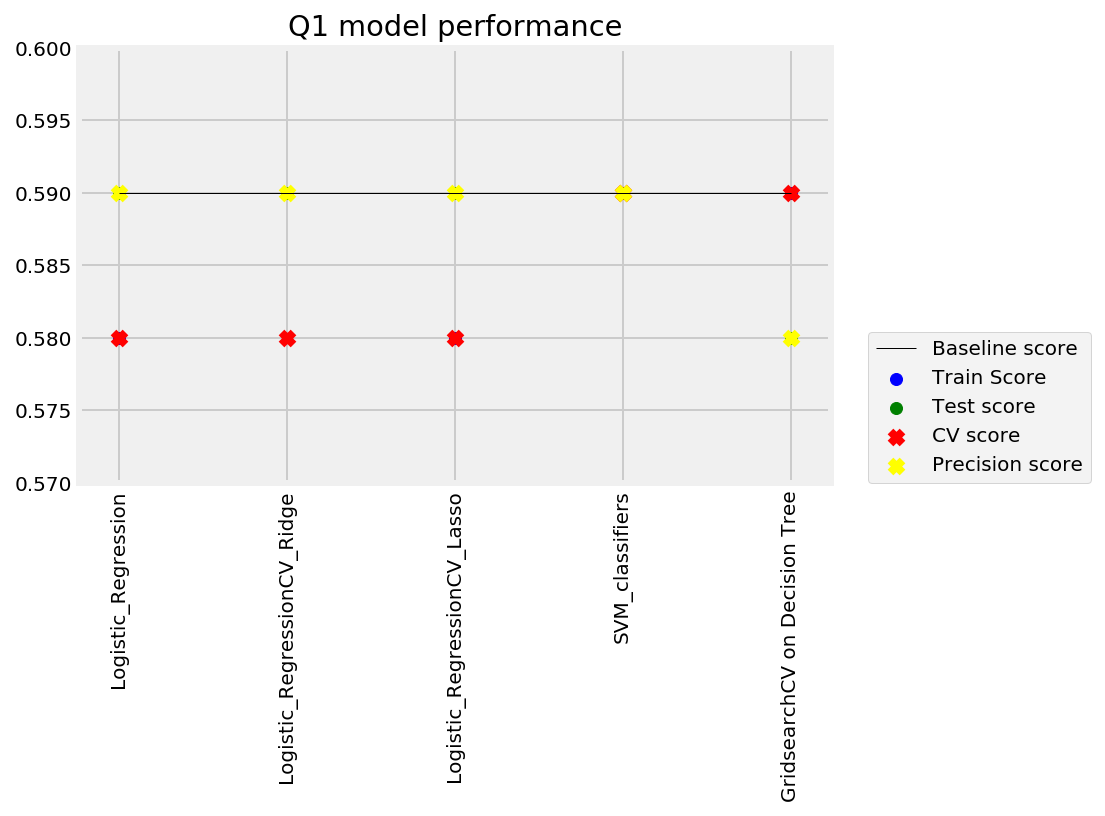

In [440]:
# Plot results
fig, ax = plt.subplots()

plt.scatter(Q1_result_df['Model'], Q1_result_df['Train_Score'], 
                 color = 'blue', label = 'Train Score', marker = 'o')
plt.scatter(Q1_result_df['Model'], Q1_result_df['Test_Score'], 
                  color = 'green', label = 'Test score', marker = 'o')
plt.scatter(Q1_result_df['Model'], Q1_result_df['CV_Score'], 
                  color = 'red', label = 'CV score', marker = 'x')
plt.scatter(Q1_result_df['Model'], Q1_result_df['Precision_Score'], 
                  color = 'yellow', label = 'Precision score', marker = 'x')
plt.plot(Q1_result_df['Model'], Q1_result_df['Baseline'], 
               color = 'black', label = 'Baseline score', linewidth=0.5)

plt.xticks(rotation = 90)
plt.title('Q1 model performance')
plt.legend(loc=(1.05,0))
axes = plt.gca()
axes.set_ylim([0.5700, 0.600])
plt.savefig('Q1_model_performance.jpg', bbox_inches="tight")
plt.show();

In [487]:
# Check ROC Curve 
fpr, tpr, threshold = roc_curve(y_test, yhat_pp_ridge[:, 1])
roc_auc = auc(fpr, tpr)

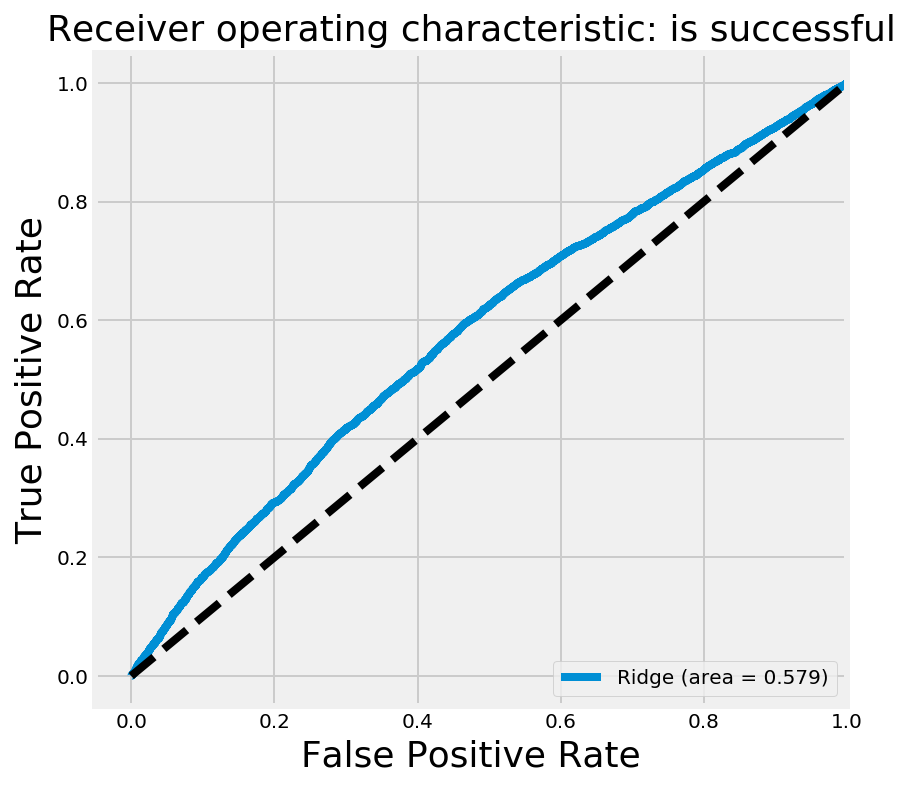

In [488]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(fpr, tpr, label='Ridge (area = %0.3f)' % roc_auc, linewidth=4)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)

ax.set_xlim([-0.05, 1.0])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.set_ylabel('True Positive Rate', fontsize=18)
ax.set_title('Receiver operating characteristic: is successful', fontsize=18)
ax.legend(loc="lower right")

plt.show()

In [489]:
fpr_lasso, tpr_lasso, threshold = roc_curve(y_test, yhat_pp_lasso[:, 1])
roc_auc_lasso = auc(fpr_lasso, tpr_lasso)

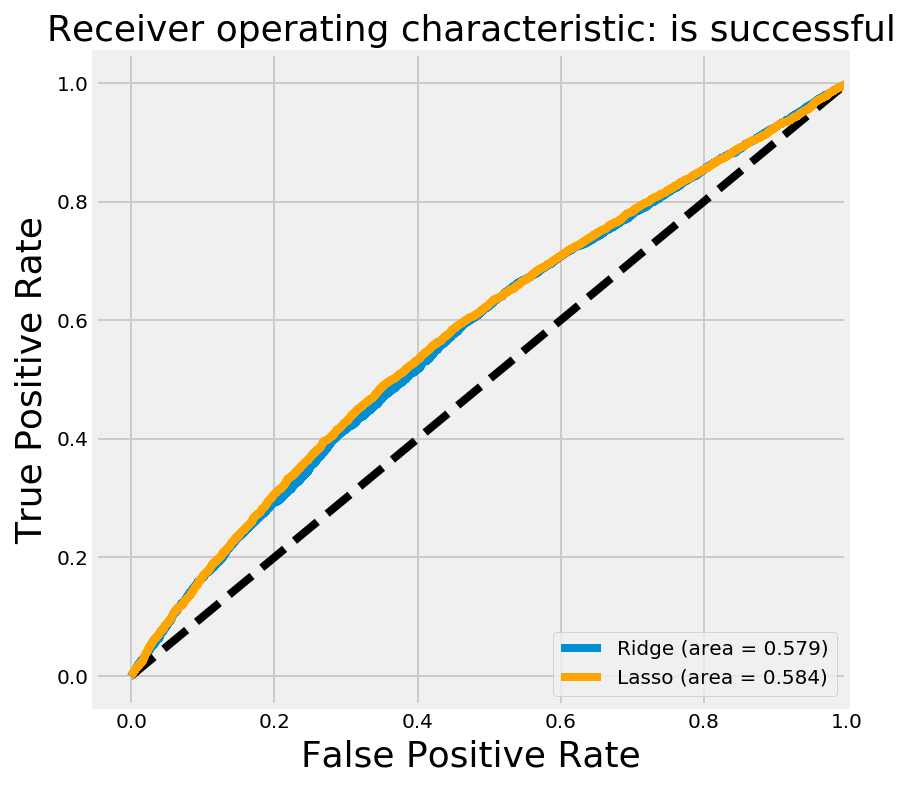

In [490]:
ax.plot(fpr_lasso, tpr_lasso, label='Lasso (area = %0.3f)' % roc_auc_lasso,
        linewidth=4, color='orange')
ax.legend(loc='lower right')
fig

In [491]:
fpr_clf_s, tpr_clf_s, threshold = roc_curve(y_test, yhat_pp_clf_s[:, 1])
roc_auc_clf_s = auc(fpr_clf_s, tpr_clf_s)

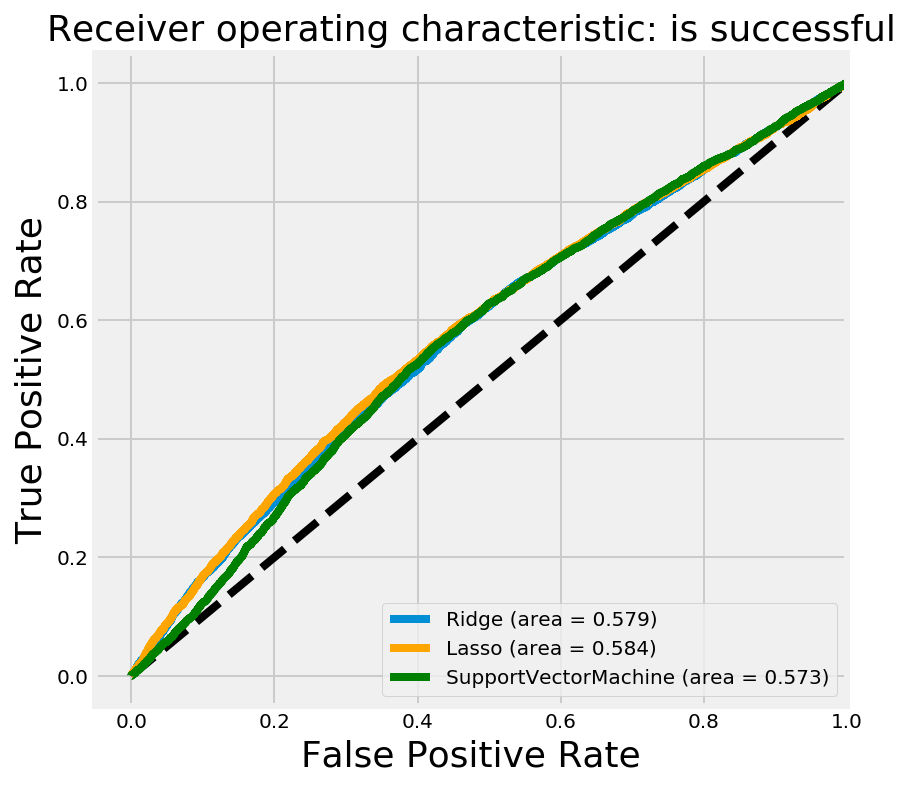

In [492]:
ax.plot(fpr_clf_s, tpr_clf_s, label='SupportVectorMachine (area = %0.3f)' % roc_auc_clf_s,
        linewidth=4, color='green')
ax.legend(loc='lower right')
fig

In [493]:
fpr_dt_gridsearch, tpr_dt_gridsearch, threshold = roc_curve(y_test, yhat_pp_dt_gridsearch[:, 1])
roc_auc_dt_gridsearch = auc(fpr_dt_gridsearch, tpr_dt_gridsearch)

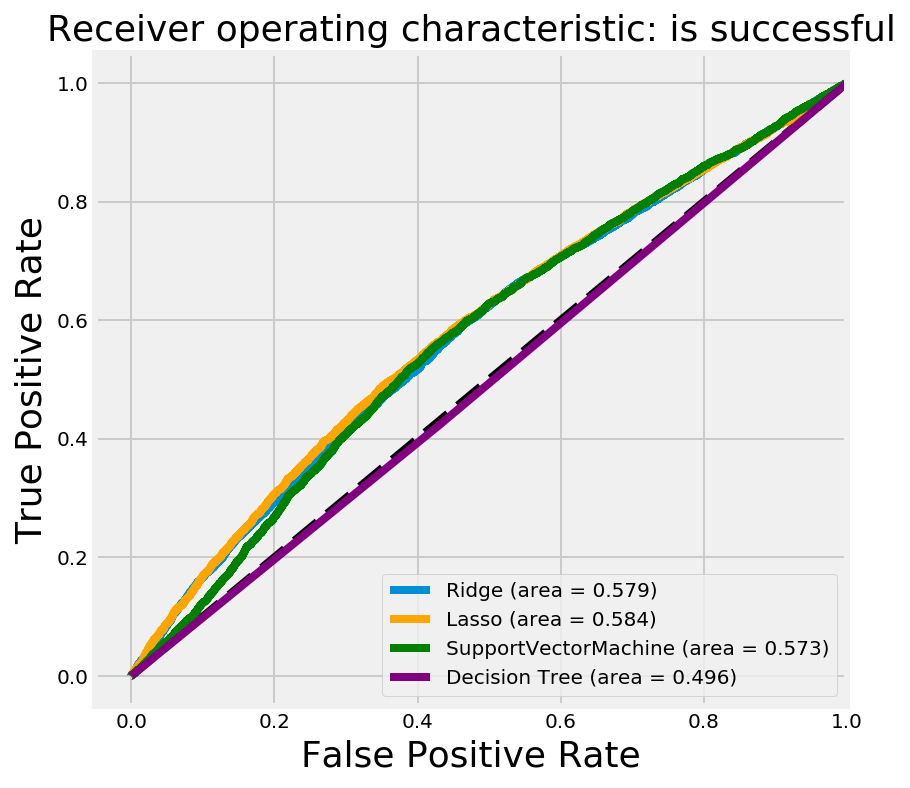

In [494]:
ax.plot(fpr_dt_gridsearch, tpr_dt_gridsearch, label='Decision Tree (area = %0.3f)' % roc_auc_dt_gridsearch,
        linewidth=4, color='purple')
ax.legend(loc='lower right')
fig